In [359]:
import datetime
import sys
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import itertools
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input, Model
from cond_rnn import ConditionalRNN
from sklearn.preprocessing import MinMaxScaler

import src.preprocessing
from src.functions import load_data, mape, TimeSeriesTensor, create_evaluation_df, series_to_supervised, plot_train_history, validation

np.set_printoptions(threshold=sys.maxsize)

In [368]:
csv_path = '../data/Dieteren_case/Consumption_15min.csv'
df = pd.read_csv(csv_path, index_col=0)

In [369]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35136 entries, 01/01/2016 00:15:00 to 01/01/2017 00:00:00
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Consumer_0 (kW)  35136 non-null  float64
dtypes: float64(1)
memory usage: 549.0+ KB


In [351]:
df.index = pd.to_datetime(df.index)
df = df.resample('H').mean()

In [363]:
temp = pd.read_csv('../data/Dieteren_case/Temp_15min.csv', index_col=0)
temp.index = pd.to_datetime(temp.index)
temp = temp.resample('H').mean()
df = df.merge(temp, how='left', left_index=True, right_index=True)

In [364]:
df.to_csv('Consumption&Temp.csv')

In [278]:
def train_test_split(df, n_test):
    test_df = df.copy()[-(n_test+23):]
    train_df = df.copy()[:-(len(test_df)-23)]
    return train_df, test_df

In [279]:
def ConditionalRNN_data_preparation(df, n_test=4380, T=24, HORIZON=24):
    df = src.preprocessing.preprocess(df, 'Belgium')
    c2 = series_to_supervised(df)
    c1 = df.iloc[:,1:9]
    c1 = c1.loc[c2.index]
    short_df = df.iloc[:,[0,1,-4,-3,-2,-1]].copy()
    #check how to formulate more correctly
    short_df = short_df[146:]
    train_df, test_df = train_test_split(short_df, n_test)
    train_c1, test_c1 = train_test_split(c1, n_test)
    train_c2, test_c2 = train_test_split(c2, n_test)
    y_scaler = MinMaxScaler()
    y_scaler.fit(train_df[['value']])
    train_c2[['value(t-24)']] = y_scaler.fit_transform(train_c2[['value(t-24)']])
    train_c2[['value(t-168)']] = y_scaler.fit_transform(train_c2[['value(t-168)']])
    X_scaler = MinMaxScaler()
    train_df[train_df.columns] = X_scaler.fit_transform(train_df)
    test_df[train_df.columns] = X_scaler.fit_transform(test_df)
    tensor_structure = {'X':(range(-T+1, 1), ['value','fractional hour_sin','fractional hour_cos','day of year_sin','day of year_cos'])}
    train_inputs = TimeSeriesTensor(train_df, 'value', HORIZON, tensor_structure)
    test_inputs = TimeSeriesTensor(test_df, 'value', HORIZON, tensor_structure)
    train_c1 = c1.reindex(train_inputs.dataframe.index)
    train_c2 = c2.reindex(train_inputs.dataframe.index)
    test_c1 = c1.reindex(test_inputs.dataframe.index)
    test_c2 = c2.reindex(test_inputs.dataframe.index)
    return train_inputs, test_inputs, train_c1, test_c1, train_c2, test_c2, y_scaler

In [280]:
def MIMO_fulldata_preparation(df, n_test=4380, T=24, HORIZON=24):
    df = src.preprocessing.preprocess(df, 'Belgium')
    df = df.merge(series_to_supervised(df), how='right', left_index=True, right_index=True)
    train_df, test_df = train_test_split(df, n_test)
    y_scaler = MinMaxScaler()
    y_scaler.fit(train_df[['value']])
    long_scaler = MinMaxScaler()
    test_df[test_df.columns] = long_scaler.fit_transform(test_df)
    train_df[train_df.columns] = long_scaler.fit_transform(train_df)
    tensor_structure = {'X':(range(-T+1, 1), train_df.columns)}
    train_inputs = TimeSeriesTensor(train_df, 'value', HORIZON, tensor_structure)
    test_inputs = TimeSeriesTensor(test_df, 'value', HORIZON, tensor_structure)
    return train_inputs, test_inputs, y_scaler

In [281]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [282]:
train_inputs, test_inputs, y_scaler = MIMO_fulldata_preparation(df)
baseline = Baseline(label_index = 0)
baseline.compile(loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanSquaredError()])
predictions_B = baseline.predict(test_inputs['X'])
eval_df_B = create_evaluation_df(predictions_B.reshape(-1,24), test_inputs, 24, y_scaler)
mape = validation(eval_df_B['prediction'], eval_df_B['actual'], 'MAPE')
mae = validation(eval_df_B['prediction'], eval_df_B['actual'], 'MAE')
rmse = validation(eval_df_B['prediction'], eval_df_B['actual'], 'RMSE')

In [283]:
print('rmse {}'.format(rmse))
print('mae {}'.format(mae))
print('mape {}'.format(mape))

rmse 225.4467847578401
mae 135.3503257596613
mape 32.519342904924315


In [360]:
NUM_CELLS = 32
MAX_EPOCHS = 100
BATCHSIZE = 32
patience = 10
HORIZON = 24

ConditionalRNN = Sequential(layers=[ConditionalRNN(NUM_CELLS, cell='LSTM'),
                                    Dense(HORIZON)])


train_inputs, test_inputs, train_c1, test_c1, train_c2, test_c2, y_scaler = ConditionalRNN_data_preparation(df, n_test=1465)
# full data LSTM MIMO compilation and fit
ConditionalRNN.compile(optimizer=tf.optimizers.Adam(), loss='mse', metrics=[tf.metrics.MeanSquaredError()])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')

history = ConditionalRNN.fit([train_inputs['X'],train_c1,train_c2], train_inputs['target'], batch_size=32, epochs=MAX_EPOCHS,
              validation_split=0.15,
              callbacks=[early_stopping], verbose=1)

#save_model(ConditionalRNN, i)
predictions = ConditionalRNN.predict([test_inputs['X'],test_c1,test_c2])
eval_df = create_evaluation_df(predictions, test_inputs, HORIZON, y_scaler)
mae = validation(eval_df['prediction'], eval_df['actual'], 'MAE')
mape = validation(eval_df['prediction'], eval_df['actual'], 'MAPE')
rmse = validation(eval_df['prediction'], eval_df['actual'], 'RMSE')

Epoch 1/100
Consider rewriting this model with the Functional API.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by pass

Epoch 35/100
190/190 [==============================] - 3s 18ms/step - loss: 0.0143 - mean_squared_error: 0.0143 - val_loss: 0.0134 - val_mean_squared_error: 0.0134
Epoch 36/100
190/190 [==============================] - 3s 18ms/step - loss: 0.0143 - mean_squared_error: 0.0143 - val_loss: 0.0135 - val_mean_squared_error: 0.0135
Epoch 37/100
190/190 [==============================] - 4s 19ms/step - loss: 0.0140 - mean_squared_error: 0.0140 - val_loss: 0.0146 - val_mean_squared_error: 0.0146
Epoch 38/100
190/190 [==============================] - 3s 18ms/step - loss: 0.0138 - mean_squared_error: 0.0138 - val_loss: 0.0147 - val_mean_squared_error: 0.0147
Epoch 39/100
190/190 [==============================] - 3s 18ms/step - loss: 0.0139 - mean_squared_error: 0.0139 - val_loss: 0.0134 - val_mean_squared_error: 0.0134
Epoch 40/100
190/190 [==============================] - 3s 18ms/step - loss: 0.0137 - mean_squared_error: 0.0137 - val_loss: 0.0137 - val_mean_squared_error: 0.0137
Epoch 41/1

In [361]:
print('rmse {}'.format(rmse))
print('mae {}'.format(mae))
print('mape {}'.format(mape))

rmse 157.0670569794876
mae 108.84075313450501
mape 21.426934111320218


In [292]:
eval_df.to_csv('Dieteren-forecast_2months.csv')

In [293]:
eval_df

,timestamp,h,prediction,actual
0,2016-11-01 00:00:00,t+1,356.318148,401.336086
1,2016-11-01 01:00:00,t+1,383.510729,398.805059
2,2016-11-01 02:00:00,t+1,414.773763,411.326981
3,2016-11-01 03:00:00,t+1,483.339040,408.129894
4,2016-11-01 04:00:00,t+1,595.384788,446.761354
...,...,...,...,...
34579,2016-12-30 20:00:00,t+24,362.652679,446.708069
34580,2016-12-30 21:00:00,t+24,350.656027,441.832513
34581,2016-12-30 22:00:00,t+24,356.095128,436.637247
34582,2016-12-30 23:00:00,t+24,333.848941,428.777743


In [294]:
day1 = eval_df[eval_df['timestamp'] == '2016-11-01 00:00:00'].copy()

In [295]:
eval_df['h'] = eval_df['h'].str.extract('(\d+)', expand=False).astype(int)

In [296]:
index = eval_df.timestamp.unique()
index_iter = iter(index)

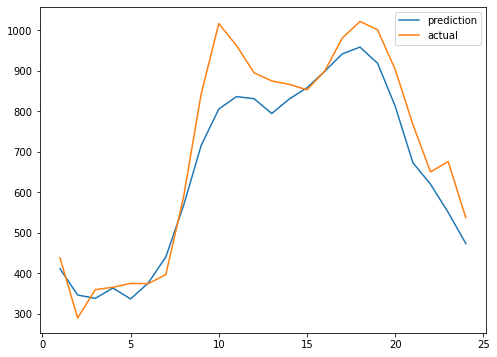

In [342]:
for _ in range(24):
    next(index_iter)
day = eval_df[eval_df['timestamp'] == next(index_iter)]
plt.plot(day.h,day.prediction, label='prediction')
plt.plot(day.h,day.actual, label='actual')
plt.legend()
plt.show()

In [343]:
NUM_CELLS = 32
MAX_EPOCHS = 100
BATCHSIZE = 32
patience = 10
HORIZON = 24

LSTMIMO = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, input_shape=(24, 15)),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(HORIZON)
])

train_inputs, test_inputs, y_scaler = MIMO_fulldata_preparation(df)
# full data LSTM MIMO compilation and fit
LSTMIMO.compile(optimizer=tf.optimizers.Adam(), loss='mse', metrics=[tf.metrics.MeanSquaredError()])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')

history = LSTMIMO.fit(train_inputs['X'], train_inputs['target'], batch_size=32, epochs=MAX_EPOCHS, validation_split=0.15,
                      callbacks=[early_stopping], verbose=1)

predictions = LSTMIMO.predict(test_inputs['X'])
eval_df = create_evaluation_df(predictions, test_inputs, HORIZON, y_scaler)
mae = validation(eval_df['prediction'], eval_df['actual'], 'MAE')
mape = validation(eval_df['prediction'], eval_df['actual'], 'MAPE')
rmse = validation(eval_df['prediction'], eval_df['actual'], 'RMSE')

Epoch 1/100
112/112 [==============================] - 3s 24ms/step - loss: 0.0790 - mean_squared_error: 0.0790 - val_loss: 0.0456 - val_mean_squared_error: 0.0456
Epoch 2/100
112/112 [==============================] - 2s 19ms/step - loss: 0.0425 - mean_squared_error: 0.0425 - val_loss: 0.0352 - val_mean_squared_error: 0.0352
Epoch 3/100
112/112 [==============================] - 2s 18ms/step - loss: 0.0311 - mean_squared_error: 0.0311 - val_loss: 0.0251 - val_mean_squared_error: 0.0251
Epoch 4/100
112/112 [==============================] - 2s 20ms/step - loss: 0.0263 - mean_squared_error: 0.0263 - val_loss: 0.0257 - val_mean_squared_error: 0.0257
Epoch 5/100
112/112 [==============================] - 2s 17ms/step - loss: 0.0247 - mean_squared_error: 0.0247 - val_loss: 0.0252 - val_mean_squared_error: 0.0252
Epoch 6/100
112/112 [==============================] - 2s 18ms/step - loss: 0.0234 - mean_squared_error: 0.0234 - val_loss: 0.0303 - val_mean_squared_error: 0.0303
Epoch 7/100
112/

In [40]:
print('rmse {}'.format(rmse))
print('mae {}'.format(mae))

rmse 144.90271518363247
mae 99.66371330971452


In [286]:
NUM_CELLS = 32
MAX_EPOCHS = 100
BATCHSIZE = 32
patience = 10
HORIZON = 24
# ConditionalRNN with the functional API.
i = Input(shape=[HORIZON, 5], name='time-series')
c1 = Input(shape=[8], name='one-hot')
c2 = Input(shape=[2], name='lags-as-features')
# add the condition tensor here.
x = ConditionalRNN(NUM_CELLS, cell='LSTM', name='cond_rnn_0')([i, c1, c2])
# Dense layer to output
x = Dense(HORIZON)(x)
ConditionalRNN = Model(inputs=[i, c1, c2], outputs=[x])

#ConditionalRNN = Sequential(layers=[ConditionalRNN(NUM_CELLS, cell='LSTM'),
#                                    Dense(HORIZON)])


train_inputs, test_inputs, train_c1, test_c1, train_c2, test_c2, y_scaler = ConditionalRNN_data_preparation(df, n_test=1465)
# full data LSTM MIMO compilation and fit
ConditionalRNN.compile(optimizer=tf.optimizers.Adam(), loss='mse', metrics=[tf.metrics.MeanSquaredError()])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')

history = ConditionalRNN.fit([train_inputs['X'],train_c1,train_c2], train_inputs['target'], batch_size=32, epochs=MAX_EPOCHS,
              validation_split=0.15,
              callbacks=[early_stopping], verbose=1)

#save_model(ConditionalRNN, i)
predictions = ConditionalRNN.predict([test_inputs['X'],test_c1,test_c2])
eval_df = create_evaluation_df(predictions, test_inputs, HORIZON, y_scaler)
mae = validation(eval_df['prediction'], eval_df['actual'], 'MAE')
rmse = validation(eval_df['prediction'], eval_df['actual'], 'RMSE')

Epoch 1/100
 54/190 [=======>......................] - ETA: 2s - loss: 0.1000 - mean_squared_error: 0.1000

KeyboardInterrupt: 